# Proyecto de Clasificación de Basura utilizando Deep Learning

**Nombre del autor**: Johnny Arica Prado

**Fecha**: 30/08/2025

## Objetivo del Proyecto

El objetivo de este proyecto es comparar el rendimiento de diferentes modelos preentrenados (MobileNetV3Small, EfficientNetB0, ResNet50) en la tarea de clasificación de basura. Usaremos un conjunto de datos proporcionado por Roboflow que contiene imágenes de diferentes tipos de basura (cartón, vidrio, plástico, metal, etc.). Evaluaremos el rendimiento de cada modelo utilizando métricas como **accuracy**, **f1_macro**, **precision_macro**, **recall_macro** y **roc_auc_macro**.


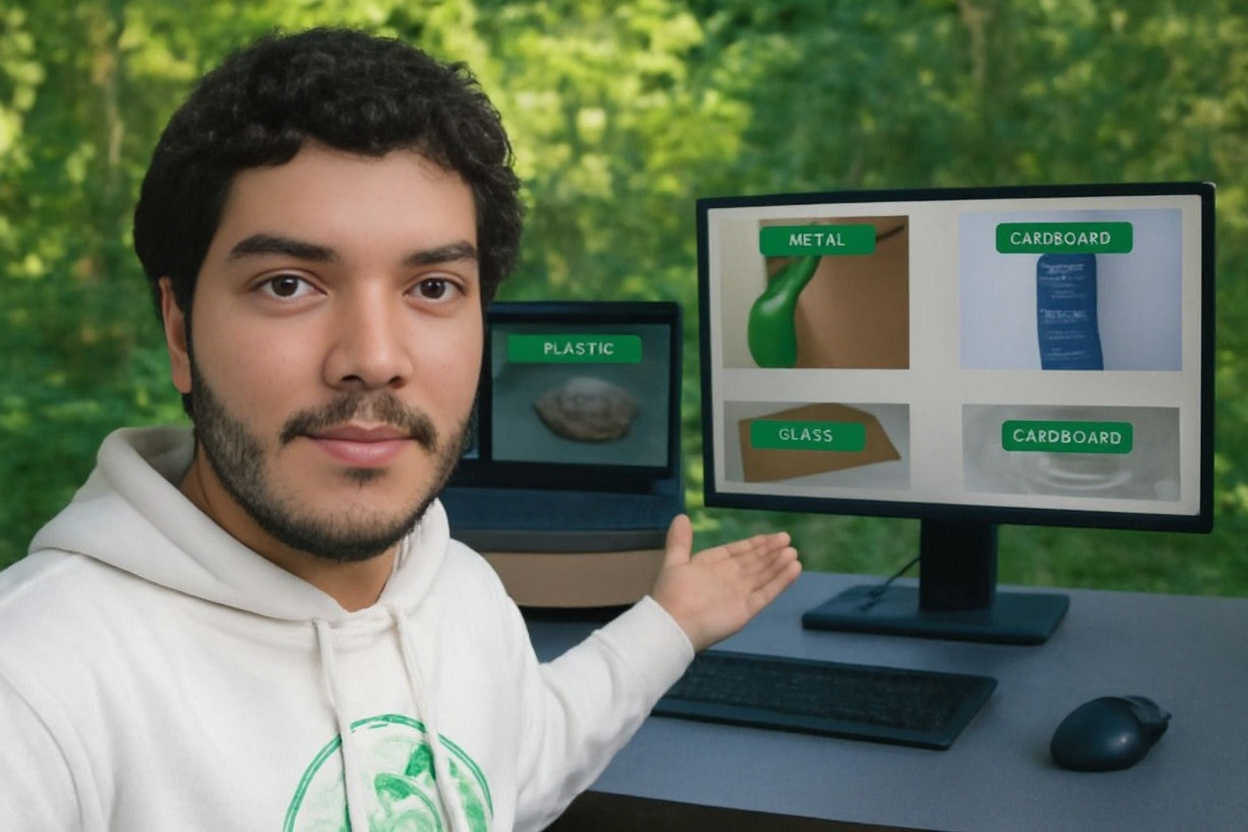

# **1. Setup (instalaciones pip, imports, selección de GPU)**

En esta sección, configuramos el entorno de trabajo. Esto incluye la verificación de la disponibilidad de la **GPU** en Google Colab, la instalación de las librerías necesarias (como TensorFlow y Keras) y la organización de las rutas de trabajo dentro de **Google Drive**.

### Pasos:
1. Instalamos las versiones correctas de las librerías necesarias.
2. Montamos **Google Drive** para acceder a los datos y modelos.
3. Definimos las rutas de las carpetas donde guardaremos los **resultados** y los **modelos entrenados**.

In [ ]:
# === 1. Setup (instalaciones, imports, selección de GPU) ===

# Verificar GPU (opcional, solo muestra si Colab te dio GPU Tesla T4 o similar)
!nvidia-smi || echo "⚠️ No se detecta GPU, revisa Entorno de ejecución > Cambiar tipo > GPU"

# ---- Limpiar instalaciones previas que causan conflictos ----
!pip uninstall -y tensorflow keras tf-keras tensorflow-text tensorflow-decision-forests

# ---- Instalar versiones compatibles con Colab 2025 (CUDA 12.4) ----
!pip install -q tensorflow==2.19.1 keras==3.5.0 scikit-learn==1.5.2 matplotlib==3.9.2 pandas==2.2.3

# ---- Montar Google Drive ----
from google.colab import drive
drive.mount('/content/drive')

# ---- Definir rutas base del proyecto ----
import os
PROJ = "DL_Proyecto_AricaJohnny_Clasificacion"  # usa exactamente tu carpeta en Drive
BASE = f"/content/drive/MyDrive/{PROJ}"
DATA_DIR = os.path.join(BASE, "data")
SPLIT_DIR = os.path.join(DATA_DIR, "split")
RESULTS = os.path.join(BASE, "results")
MODELS = os.path.join(BASE, "models")

for d in [DATA_DIR, SPLIT_DIR, RESULTS, MODELS]:
    os.makedirs(d, exist_ok=True)

# ---- Imports principales ----
import zipfile, glob, shutil, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score
)

print("✅ Setup completo - TensorFlow:", tf.__version__)

Sun Aug 24 03:43:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **2. Datos (carga, ruta/fuente, particiones)**

Para este proyecto, hemos utilizado un conjunto de datos de **clasificación de basura** disponible en **Roboflow**. El conjunto de datos se encuentra en un archivo **ZIP** y contiene imágenes divididas en tres particiones: **train** (entrenamiento), **valid** (validación) y **test** (prueba).

En esta sección, vamos a descomprimir el archivo, contar cuantas imagenes hay en cada particion y de que tipo.


In [ ]:
# === 2. Datos (usar splits de Roboflow tal cual) ===

import os, glob, zipfile, pandas as pd

# Ruta del ZIP original
DATA_ZIP = os.path.join(DATA_DIR, "garbage_dataset.zip")  # cambia si tu archivo tiene otro nombre
EXTRACT_DIR = os.path.join(DATA_DIR, "roboflow_splits")

# --- Descomprimir una sola vez ---
if os.path.exists(DATA_ZIP) and not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(DATA_ZIP, "r") as zf:
        zf.extractall(EXTRACT_DIR)

# Definir rutas directas a los splits de Roboflow
TRAIN_DIR = os.path.join(EXTRACT_DIR, "train")
VAL_DIR   = os.path.join(EXTRACT_DIR, "valid")
TEST_DIR  = os.path.join(EXTRACT_DIR, "test")

print("📂 Usando dataset Roboflow directamente en:")
print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR:", VAL_DIR)
print("TEST_DIR:", TEST_DIR)

# --- Función para contar imágenes ---
def count_images(path):
    report = []
    for cls in sorted(os.listdir(path)):
        cdir = os.path.join(path, cls)
        if os.path.isdir(cdir):
            report.append({"class": cls, "images": len(glob.glob(os.path.join(cdir, '*')))})
    return pd.DataFrame(report)

print("\nConteos TRAIN:\n", count_images(TRAIN_DIR))
print("\nConteos VAL:\n", count_images(VAL_DIR))
print("\nConteos TEST:\n", count_images(TEST_DIR))


📂 Usando dataset Roboflow directamente en:
TRAIN_DIR: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/data/roboflow_splits/train
VAL_DIR: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/data/roboflow_splits/valid
TEST_DIR: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/data/roboflow_splits/test

Conteos TRAIN:
        class  images
0  cardboard     520
1      glass     617
2      metal     505
3      paper     719
4    plastic     559
5      trash     172

Conteos VAL:
        class  images
0  cardboard      65
1      glass      94
2      metal      90
3      paper     128
4    plastic     102
5      trash      25

Conteos TEST:
        class  images
0  cardboard      40
1      glass      55
2      metal      33
3      paper      53
4    plastic      57
5      trash      14


# **3. Preprocesamiento**

Cargar las imágenes en **tensores** con **TensorFlow** y aplicar **data augmentation** en las imágenes de entrenamiento para mejorar el rendimiento del modelo. Además, las imágenes serán redimensionadas a **224x224 píxeles** para adaptarse a los modelos preentrenados que vamos a usar.

El conjunto de datos contiene 6 clases: **cartón, vidrio, plástico, metal, papel y basura**.

In [ ]:
# === 3. Preprocesamiento ===

import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = 224
BATCH = 32
seed = 42

# Cargar datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=True,
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False
)

# Nombres de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("✅ Clases detectadas:", class_names, "| Total:", num_classes)

# Data augmentation (solo para entrenamiento)
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Optimizar pipeline con prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x,y: (data_augment(x), y)).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 3092 files belonging to 6 classes.
Found 504 files belonging to 6 classes.
Found 252 files belonging to 6 classes.
✅ Clases detectadas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] | Total: 6


# **4. Entrenamiento A/B/C**

Para este proyecto, entrenamos tres modelos preentrenados: **MobileNetV3Small**, **EfficientNetB0** y **ResNet50**. Estos modelos han sido previamente entrenados en el conjunto de datos **ImageNet**, lo que les permite extraer características generales de las imágenes.

Usamos **Transfer Learning** con **fine-tuning** para adaptar estos modelos a nuestro problema de clasificación de basura. Entrenamos cada modelo durante **20 épocas** utilizando el optimizador **Adam** y empleamos los callbacks de **EarlyStopping** y **ReduceLROnPlateau** para evitar el sobreajuste y optimizar el proceso de aprendizaje.

### Pasos:
1. Cargar los modelos preentrenados.
2. Añadir una capa de salida personalizada para la clasificación de 6 clases.
3. Entrenar los modelos en el conjunto de entrenamiento y validación.

In [ ]:
# === 4. Entrenamiento A/B/C ===

from tensorflow.keras.applications import (
    MobileNetV3Small, EfficientNetB0, ResNet50
)
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as pre_mnv3
from tensorflow.keras.applications.efficientnet import preprocess_input as pre_eff
from tensorflow.keras.applications.resnet import preprocess_input as pre_res
from tensorflow.keras import layers, Model
import tensorflow as tf

IMG_SIZE = 224
BATCH = 32
seed = 42

# Función genérica para construir clasificador
def build_classifier(base_model, preprocess, img_size=224, num_classes=6, train_base=False):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = preprocess(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)

    base_model.trainable = train_base  # False: solo cabeza, True: fine-tune
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Instancias de cada variante
baseA = MobileNetV3Small(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
modelA = build_classifier(baseA, pre_mnv3, IMG_SIZE, num_classes)

baseB = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
modelB = build_classifier(baseB, pre_eff, IMG_SIZE, num_classes)

baseC = ResNet50(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
modelC = build_classifier(baseC, pre_res, IMG_SIZE, num_classes)

# Callbacks
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2)
]

# Entrenamientos
histA = modelA.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cb)
histB = modelB.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cb)
histC = modelC.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cb)

# Guardar modelos en formato .keras (nuevo formato)
modelA.save(os.path.join(MODELS, "A_MobileNetV3Small.keras"))
modelB.save(os.path.join(MODELS, "B_EfficientNetB0.keras"))
modelC.save(os.path.join(MODELS, "C_ResNet50.keras"))


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 746s 7s/step - accuracy: 0.4157 - loss: 1.5497 - val_accuracy: 0.7202 - val_loss: 0.7755 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 485ms/step - accuracy: 0.7198 - loss: 0.7865 - val_accuracy: 0.7718 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 483ms/step - accuracy: 0.7731 - loss: 0.6385 - val_accuracy: 0.7937 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 480ms/step - accuracy: 0.8012 - loss: 0.5653 - val_accuracy: 0.8016 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 469ms/step - accuracy: 0.8176 - loss: 0.5379 - val_accuracy: 0.8135 - val_loss: 0.5311 - learning_rate: 0.0010
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 485ms/step - accuracy: 0.8361 - loss: 0.4882

# **5. Evaluación (test) → gráficos por métrica y modelo**

Una vez entrenados los modelos, evaluamos su rendimiento en el conjunto de prueba. Calculamos diversas métricas como **accuracy**, **f1_macro**, **precision_macro**, **recall_macro** y **roc_auc_macro**, que nos permiten analizar la capacidad del modelo para clasificar correctamente las imágenes de cada clase.

Además, generamos la **matriz de confusión** para visualizar el rendimiento del modelo en cada clase.

### Pasos:
1. Cargar los modelos entrenados.
2. Evaluar los modelos en el conjunto de prueba.
3. Calcular las métricas de rendimiento.
4. Generar la matriz de confusión.


Buscando en: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/A_MobileNetV3Small.keras
Buscando en: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/B_EfficientNetB0.keras
Buscando en: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/C_ResNet50.keras
Modelos detectados:
 - MobileNetV3Small: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/A_MobileNetV3Small.keras
 - EfficientNetB0: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/B_EfficientNetB0.keras
 - ResNet50: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/C_ResNet50.keras


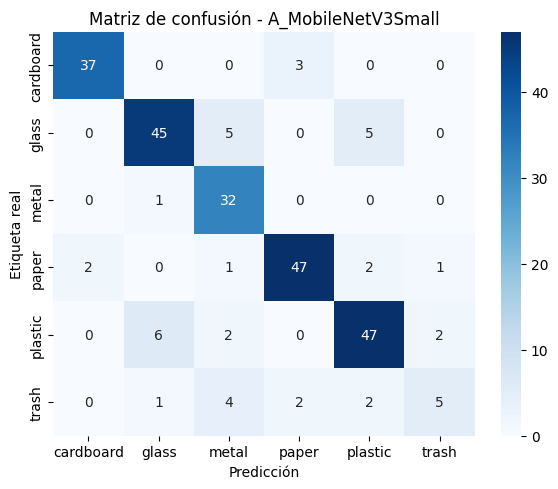

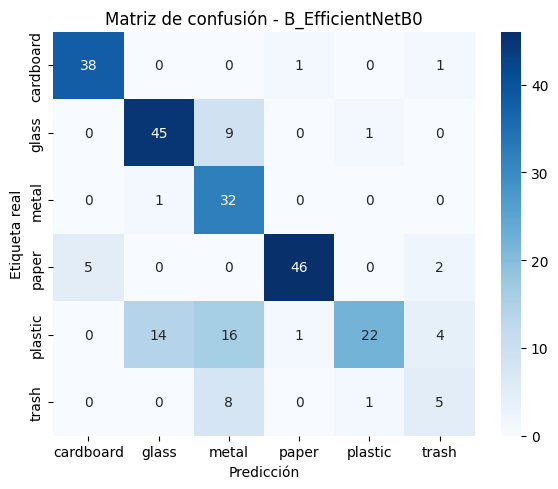

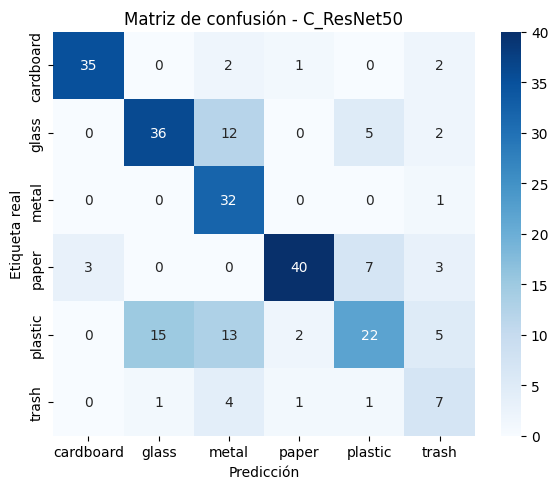

,modelo,accuracy_test,f1_macro_test,precision_macro_test,recall_macro_test,roc_auc_macro_test
0,A_MobileNetV3Small,0.845238,0.797142,0.815530,0.796896,0.962869
1,B_EfficientNetB0,0.746032,0.698341,0.736283,0.724819,0.946678
2,C_ResNet50,0.682540,0.658628,0.668160,0.689987,0.929025


In [ ]:
# === 5. Evaluación (test) ===

import numpy as np
import seaborn as sns
import os
import glob
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 5.1: detectar modelos entrenados ----------
def find_model_file(model_dir):
    # Asegurarse de que busca correctamente en la carpeta models
    for ext in [".keras"]:
        # Cambié la ruta BASE, usa la correcta de tu Google Drive
        search_path = os.path.join(BASE, "models", f"{model_dir}{ext}")
        print(f"Buscando en: {search_path}")  # Imprimir las rutas que se están buscando
        files = glob.glob(search_path)
        if files:
            return files[0]
    return None

# --- Importar funciones de preprocesamiento de cada modelo ---
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as pre_mnv3
from tensorflow.keras.applications.efficientnet import preprocess_input as pre_eff
from tensorflow.keras.applications.resnet import preprocess_input as pre_res

# --- Diccionario con información sobre los modelos ---
MODEL_REGISTRY = {
    "MobileNetV3Small": {
        "path": find_model_file("A_MobileNetV3Small"),
        "pre": pre_mnv3,
        "size": (224, 224)
    },
    "EfficientNetB0": {
        "path": find_model_file("B_EfficientNetB0"),
        "pre": pre_eff,
        "size": (224, 224)
    },
    "ResNet50": {
        "path": find_model_file("C_ResNet50"),
        "pre": pre_res,
        "size": (224, 224)
    }
}

# --- Verificación de los modelos detectados ---
print("Modelos detectados:")
for model_name, model_info in MODEL_REGISTRY.items():
    if model_info['path']:
        print(f" - {model_name}: {model_info['path']}")
    else:
        print(f" - {model_name}: No encontrado")

# --- Cargar los modelos detectados ---
modelA = load_model(MODEL_REGISTRY["MobileNetV3Small"]['path'])
modelB = load_model(MODEL_REGISTRY["EfficientNetB0"]['path'])
modelC = load_model(MODEL_REGISTRY["ResNet50"]['path'])

# --- Función de evaluación con preprocesamiento explícito ---
def eval_model(model, name):
    y_prob, y_true = [], []
    for x, y in test_ds:
        # Asegurarse de que las imágenes sean preprocesadas correctamente
        if name == "A_MobileNetV3Small":
            x = pre_mnv3(x)  # Preprocesamiento específico para MobileNetV3
        elif name == "B_EfficientNetB0":
            x = pre_eff(x)  # Preprocesamiento específico para EfficientNetB0
        elif name == "C_ResNet50":
            x = pre_res(x)  # Preprocesamiento específico para ResNet50

        p = model.predict(x, verbose=0)
        y_prob.append(p)
        y_true.append(y.numpy())

    y_prob = np.vstack(y_prob)
    y_true = np.vstack(y_true)

    y_pred = y_prob.argmax(axis=1)
    y_true_lab = y_true.argmax(axis=1)

    # --- Métricas ---
    acc = (y_pred == y_true_lab).mean()
    f1m = f1_score(y_true_lab, y_pred, average="macro")
    prm = precision_score(y_true_lab, y_pred, average="macro")
    rcm = recall_score(y_true_lab, y_pred, average="macro")
    aucm = roc_auc_score(y_true, y_prob, average="macro", multi_class="ovr")

    # --- Matriz de confusión ---
    cm = confusion_matrix(y_true_lab, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de confusión - {name}")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicción")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS, f"confusion_{name}.png"), dpi=150)
    plt.show()

    return {
        "modelo": name,
        "accuracy_test": acc,
        "f1_macro_test": f1m,
        "precision_macro_test": prm,
        "recall_macro_test": rcm,
        "roc_auc_macro_test": aucm
    }

# --- Evaluar los tres modelos ---
resA = eval_model(modelA, "A_MobileNetV3Small")
resB = eval_model(modelB, "B_EfficientNetB0")
resC = eval_model(modelC, "C_ResNet50")

# --- Guardar los resultados en un DataFrame ---
df = pd.DataFrame([resA, resB, resC])
df.to_csv(os.path.join(RESULTS, "metricas_test.csv"), index=False)

# Mostrar el DataFrame
df


## Gráficos Comparativos de Métricas

Para facilitar la comparación entre los modelos, generamos gráficos de barras para cada una de las métricas evaluadas (accuracy, f1_macro, precision_macro, etc.). Esto nos permite ver de manera visual qué modelo tiene el mejor rendimiento en cada métrica.

A continuación, se presentan los gráficos comparativos para cada una de las métricas seleccionadas.

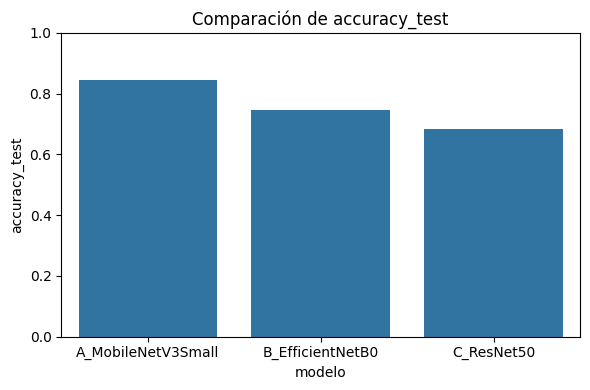

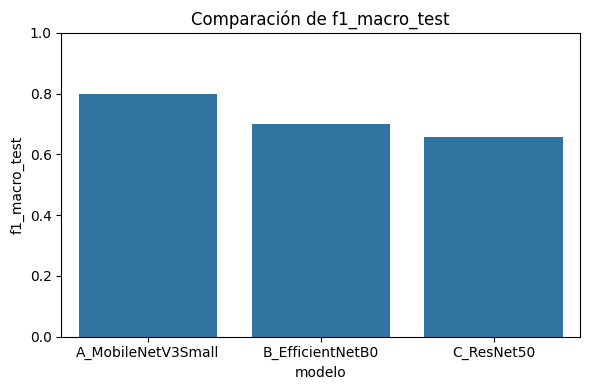

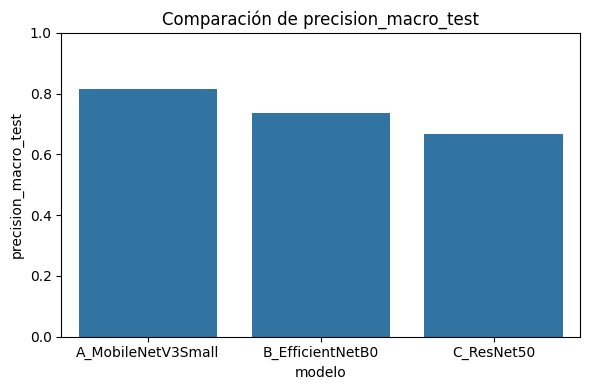

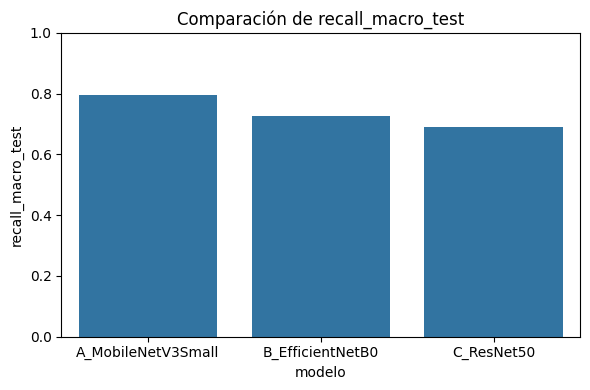

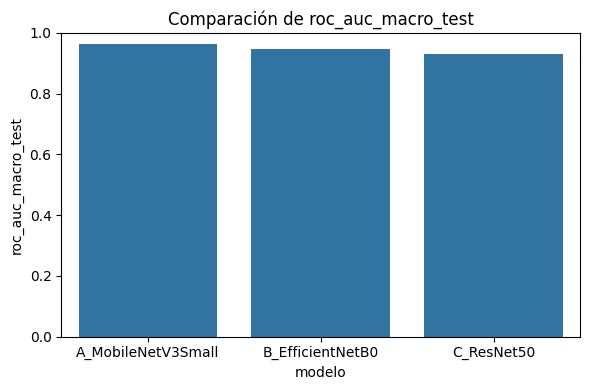

In [ ]:
# === Gráficos comparativos de métricas ===

# Lista de métricas a comparar
metrics = ["accuracy_test", "f1_macro_test", "precision_macro_test", "recall_macro_test", "roc_auc_macro_test"]

# Generar gráficos para cada métrica
for m in metrics:
    plt.figure(figsize=(6,4))  # Tamaño del gráfico
    sns.barplot(x="modelo", y=m, data=df)  # Gráfico de barras
    plt.title(f"Comparación de {m}")  # Título del gráfico
    plt.ylim(0, 1)  # Rango de las métricas (de 0 a 1)
    plt.tight_layout()  # Ajustar el diseño para evitar sobreposiciones
    plt.savefig(os.path.join(RESULTS, f"metric_{m}.png"), dpi=150)  # Guardar la imagen
    plt.show()  # Mostrar el gráfico


## Curvas de Entrenamiento (Loss y Accuracy)

Las curvas de entrenamiento muestran la evolución de las métricas de **accuracy** y **loss** a lo largo de las **épocas**. Estas curvas nos permiten analizar cómo el modelo fue mejorando durante el entrenamiento y si hubo sobreajuste o subajuste.

A continuación, se muestran las curvas de **accuracy** y **loss** para cada modelo entrenado.

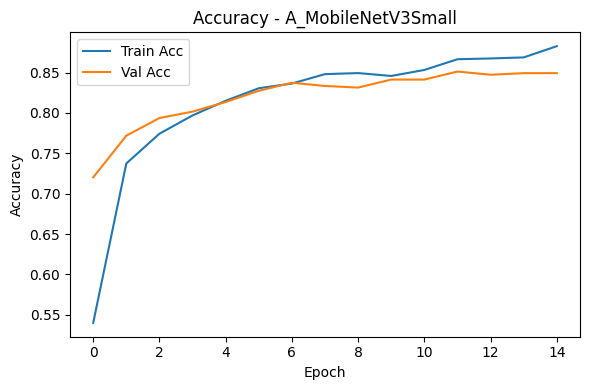

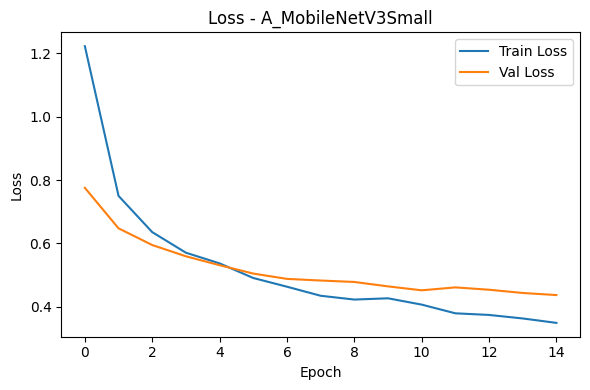

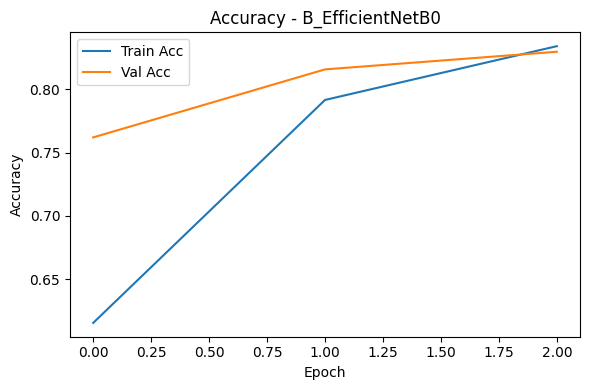

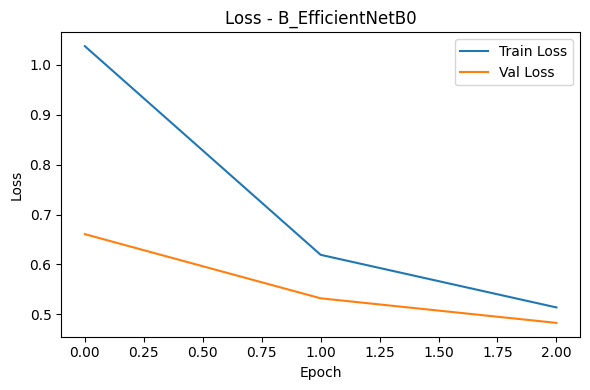

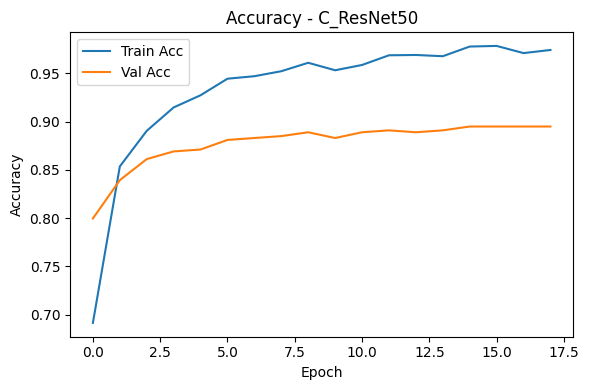

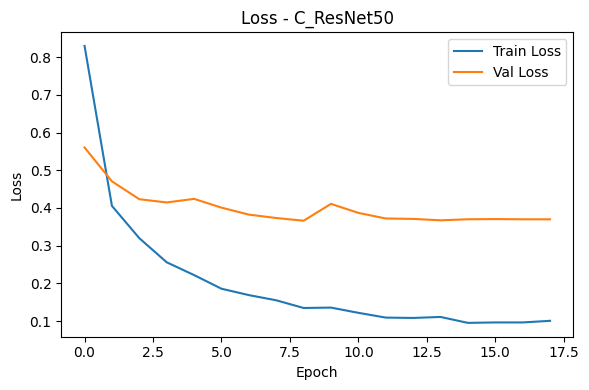

In [ ]:
# === Curvas de entrenamiento (loss y accuracy) ===

def plot_history(hist, name):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["accuracy"], label="Train Acc")
    plt.plot(hist.history["val_accuracy"], label="Val Acc")
    plt.title(f"Accuracy - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS, f"train_acc_{name}.png"), dpi=150)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"], label="Train Loss")
    plt.plot(hist.history["val_loss"], label="Val Loss")
    plt.title(f"Loss - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS, f"train_loss_{name}.png"), dpi=150)
    plt.show()

# Graficar para los 3 modelos
plot_history(histA, "A_MobileNetV3Small")
plot_history(histB, "B_EfficientNetB0")
plot_history(histC, "C_ResNet50")


# **6. Inferencia de ejemplo (capturas obligatorias)**

En esta sección, realizamos inferencias utilizando imágenes de prueba. Para cada imagen, mostramos la **etiqueta real**, la **predicción** del modelo y la **probabilidad** asociada a la predicción. Esto nos ayuda a visualizar cómo el modelo realiza la clasificación en ejemplos concretos.

A continuación, se presentan las inferencias de ejemplo para cada modelo.


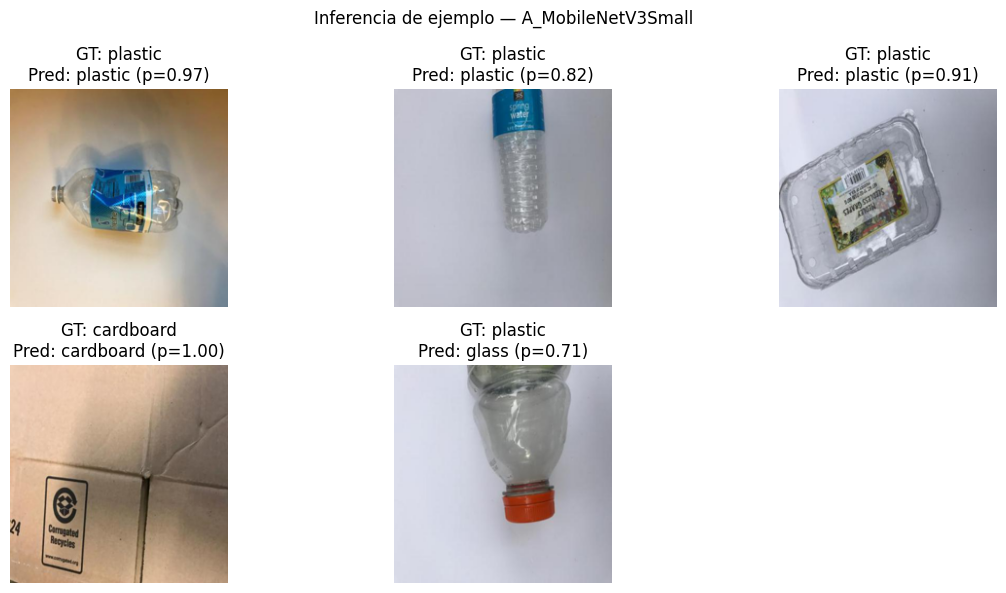

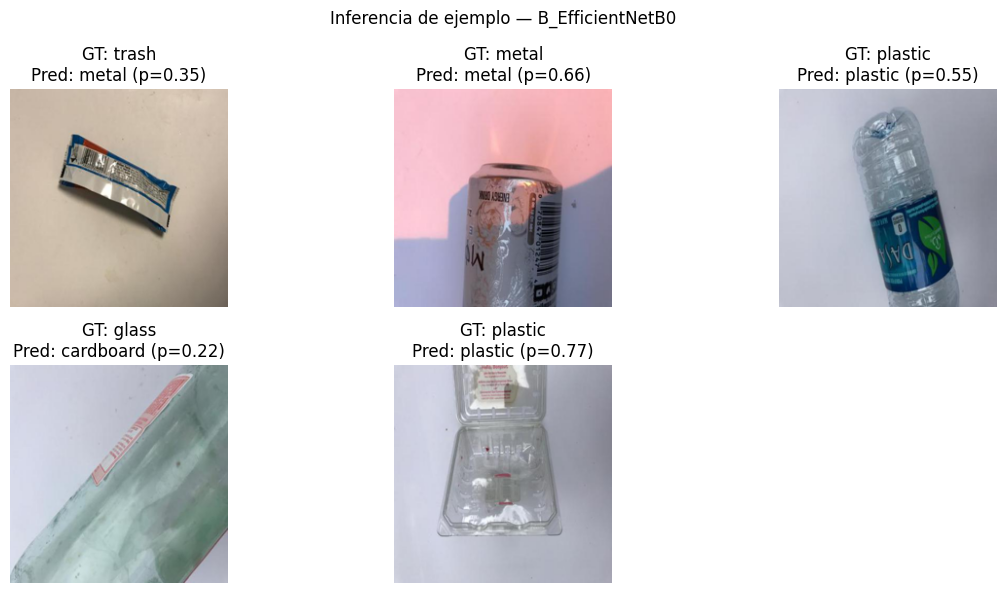

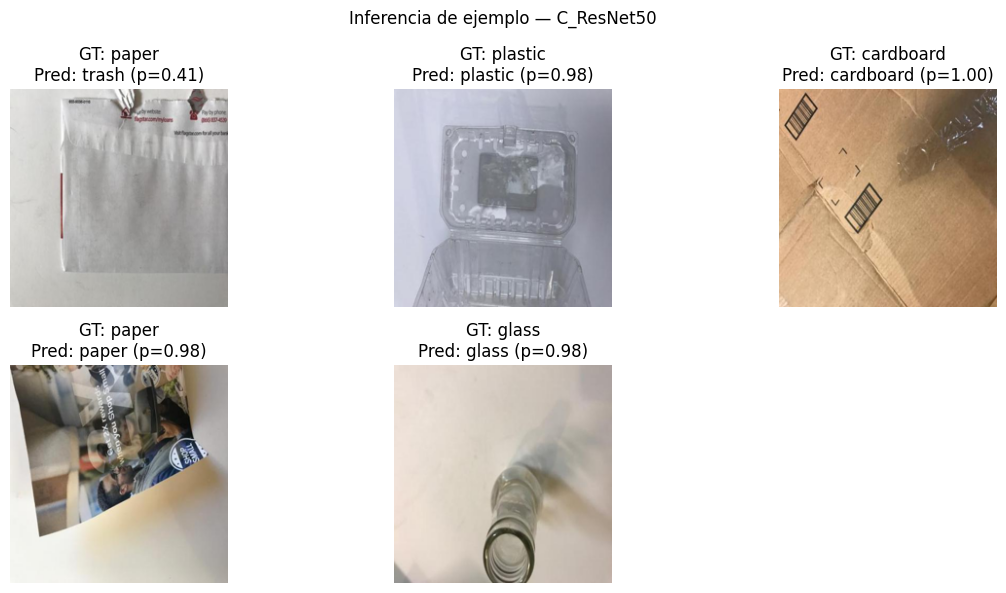

In [ ]:
# === 6. Inferencia de ejemplo (obligatoria) ===

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import glob
import PIL.Image as Image
from tensorflow.keras.models import load_model

# Función para muestrear imágenes del directorio
def sample_images_from_dir(root, n=5):
    imgs = []
    for cls in class_names:
        imgs += glob.glob(os.path.join(root, cls, "*"))
    random.shuffle(imgs)
    return imgs[:n]

# Función para hacer la predicción sobre una imagen
def predict_image(path, model, preprocess, img_size=224):
    img = Image.open(path).convert("RGB").resize((img_size,img_size))
    x = np.array(img)[None, ...].astype("float32")
    x = preprocess(x)  # Preprocesamiento de la imagen
    prob = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(prob))
    return img, idx, prob

# Función para generar paneles de inferencia
def make_inference_panel(model, preprocess, model_name, out_png):
    paths = sample_images_from_dir(TEST_DIR, n=5)  # Tomar 5 imágenes aleatorias
    plt.figure(figsize=(12,6))
    for i, p in enumerate(paths, 1):
        img, idx, prob = predict_image(p, model, preprocess, IMG_SIZE)  # Preprocesamiento dentro del modelo
        true_cls = os.path.basename(os.path.dirname(p))
        pred_cls = class_names[idx]
        conf = float(prob[idx])
        ax = plt.subplot(2,3,i)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"GT: {true_cls}\nPred: {pred_cls} (p={conf:.2f})")
    plt.suptitle(f"Inferencia de ejemplo — {model_name}")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()

# --- Cargar los modelos guardados en formato .keras ---
modelA = load_model('/content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/A_MobileNetV3Small.keras')
modelB = load_model('/content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/B_EfficientNetB0.keras')
modelC = load_model('/content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/C_ResNet50.keras')

# --- Realizar inferencias y guardar los resultados en imágenes ---
make_inference_panel(modelA, pre_mnv3, "A_MobileNetV3Small", os.path.join(RESULTS, "inferencias_A.png"))
make_inference_panel(modelB, pre_eff, "B_EfficientNetB0", os.path.join(RESULTS, "inferencias_B.png"))
make_inference_panel(modelC, pre_res, "C_ResNet50", os.path.join(RESULTS, "inferencias_C.png"))


# **7. Guardado de resultados (figuras/tablas en /results)**

Para mantener un registro de todos los artefactos generados durante el proyecto (gráficos, tablas, modelos, etc.), hemos creado un archivo **`artefactos.json`** que lista todos los archivos guardados en la carpeta **`RESULTS`**. Esto incluye las **matrices de confusión**, los **gráficos de métricas** y los **modelos entrenados**.

Este archivo también enumera los modelos entrenados guardados en formato **`.keras`**, listando las rutas para su acceso posterior.

In [ ]:
# === 7. Guardado y resumen de artefactos ===
import json, pathlib
artifacts = sorted([str(p) for p in pathlib.Path(RESULTS).glob("*")])
with open(os.path.join(RESULTS, "artefactos.json"), "w") as f:
    json.dump({"results": artifacts}, f, indent=2)

print("Guardados en /results:")
for a in artifacts: print(" -", a)

print("\nModelos en /models:")
for a in sorted([str(p) for p in pathlib.Path(MODELS).glob("*.keras")]):
    print(" -", a)

Guardados en /results:
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/artefactos.json
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/confusion_A_MobileNetV3Small.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/confusion_B_EfficientNetB0.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/confusion_C_ResNet50.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/inferencias_A.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/inferencias_B.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/inferencias_C.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/metric_accuracy_test.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/metric_f1_macro_test.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/metric_precision_macro_test.png
 - /content/driv